# Integrating Cite-seq

## Load libraries and data

In [1]:
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
from mudata import MuData
import seaborn as sns
import mudata as md
import scanpy as sc
import muon as mu
import numpy as np
import anndata

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = sc.read_h5ad("./cite-seq/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
data

AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


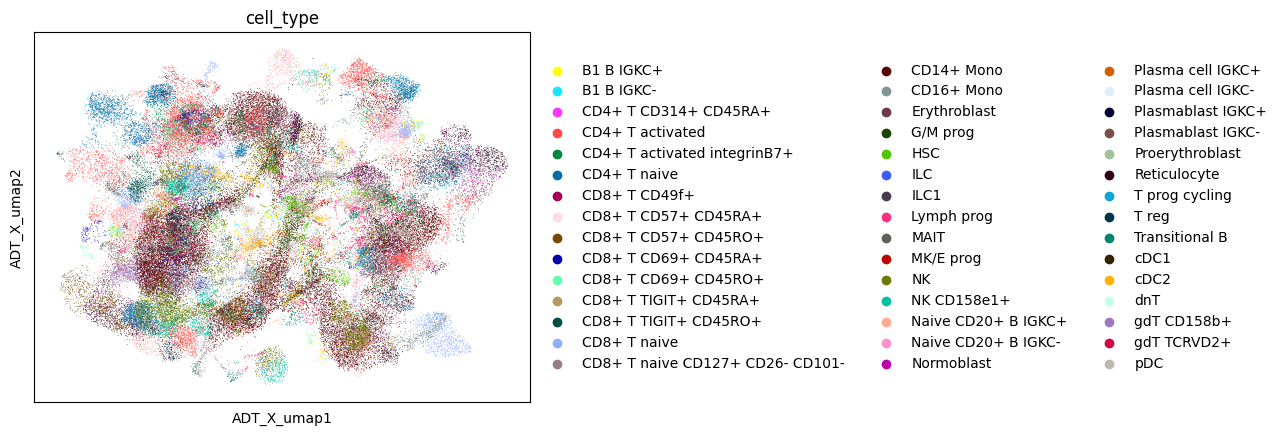

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


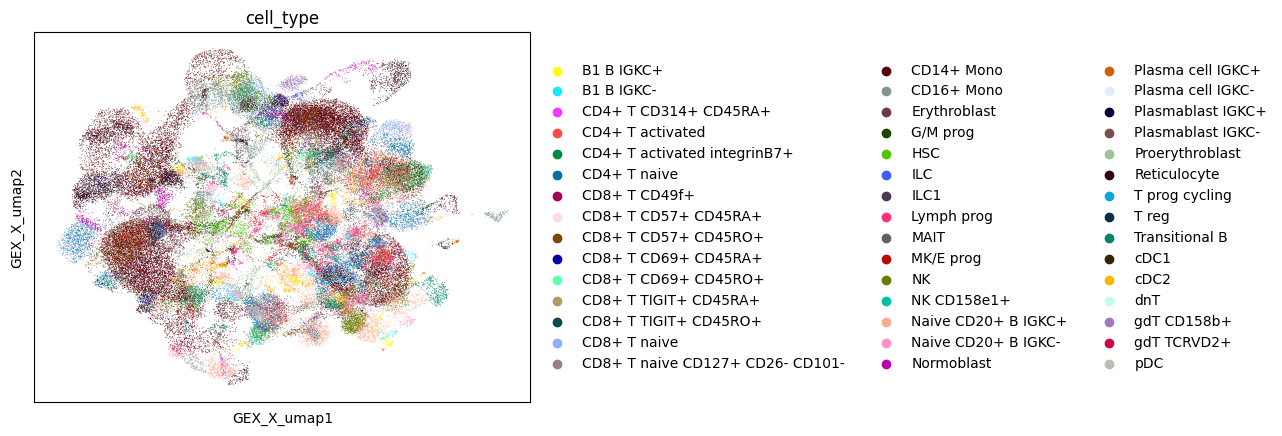

In [13]:
sc.pl.embedding(data, color ='cell_type', basis='ADT_X_umap')
sc.pl.embedding(data, color ='cell_type', basis='GEX_X_umap')

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


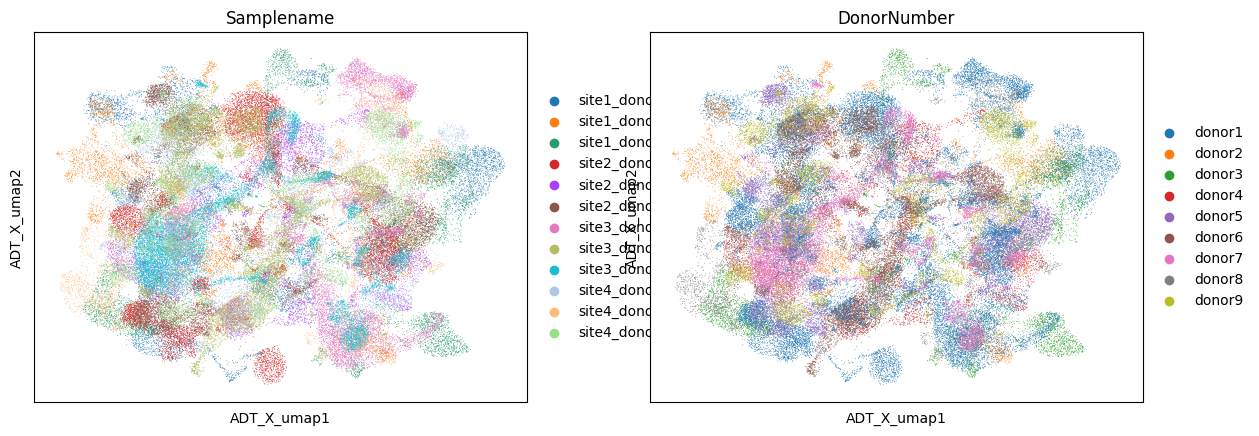

In [10]:
sc.pl.embedding(data, color =['Samplename','DonorNumber'] , basis='ADT_X_umap')

In [16]:
adata = data[data.obs['DonorNumber']== 'donor1', :]

In [20]:
adata

View of AnnData object with n_obs × n_vars = 30669 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism', 'cell_type_colors', 'Samplename_colors', 'DonorNumber_colors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


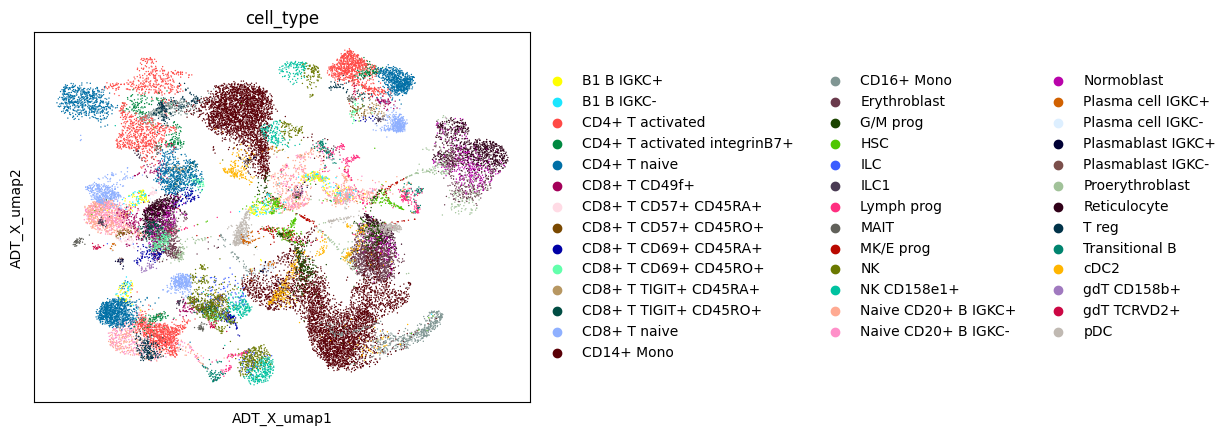

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


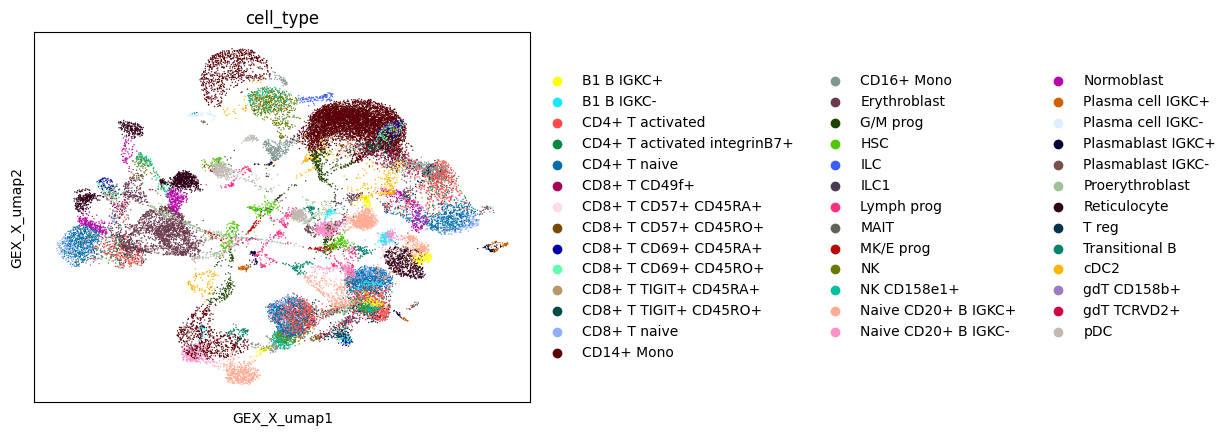

In [19]:
sc.pl.embedding(adata, color ='cell_type', basis='ADT_X_umap')
sc.pl.embedding(adata, color ='cell_type', basis='GEX_X_umap')

### PREPROCESSING (Customized)

We use scanpy for the feature screening

In [21]:
X = adata.X
X_gene = X[:,adata.var['feature_types']=='GEX']
X_adt = X[:,adata.var['feature_types']=='ADT']

In [22]:
X_gene.shape, X_adt.shape

((30669, 13953), (30669, 134))

In [23]:
Agene = sc.AnnData(X_gene)

In [24]:
Adt = sc.AnnData(X_adt)

In [25]:
sc.pp.filter_genes(Agene, min_cells = 50)

In [26]:
sc.pp.normalize_total(Agene, target_sum=1e4)
sc.pp.log1p(Agene)

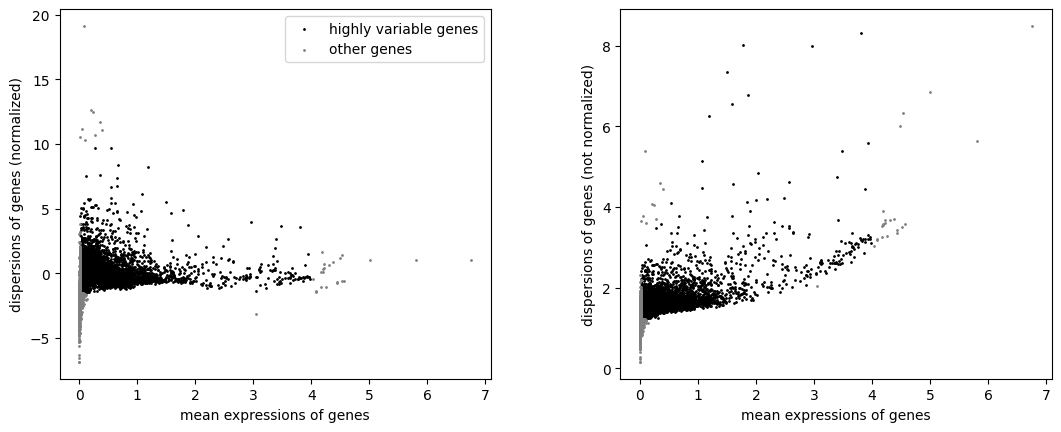

In [27]:
sc.pp.highly_variable_genes(Agene, min_mean=0.02, max_mean=4, min_disp= -1.5, max_disp = 10)
sc.pl.highly_variable_genes(Agene)

In [29]:
HVG = Agene[:, Agene.var['highly_variable'] == True]

### construct MuData object

In [52]:
mdata = MuData({"rna": HVG, "adt": Adt})

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


In [54]:
mdata.obs.index = adata.obs.index
mdata.obs['celltype'] = adata.obs['cell_type']
mdata.obsm = adata.obsm

In [55]:
mdata

MuData object with n_obs × n_vars = 30669 × 11863
  obs:	'celltype'
  obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
  2 modalities
    rna:	30669 x 11729
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'group'
      uns:	'log1p', 'hvg'
    adt:	30669 x 134
      var:	'group'

### Training

In [44]:
import TriTan

#### Customize your TriTan model

decide the number of the svd components for each mod

In [56]:
svd = {'rna': [50,300],  'adt': [50,300]}

In [57]:
tritan= TriTan.TriTan(n_component= svd, resolution = 1)

In [58]:
tritan.fit(mdata)

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:225: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:225: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


In [60]:
mdata

MuData object with n_obs × n_vars = 30669 × 11863
  obs:	'celltype', 'tritan_cluster'
  obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'tritan_umap'
  2 modalities
    rna:	30669 x 11729
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'group'
      uns:	'log1p', 'hvg'
    adt:	30669 x 134
      var:	'group'

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


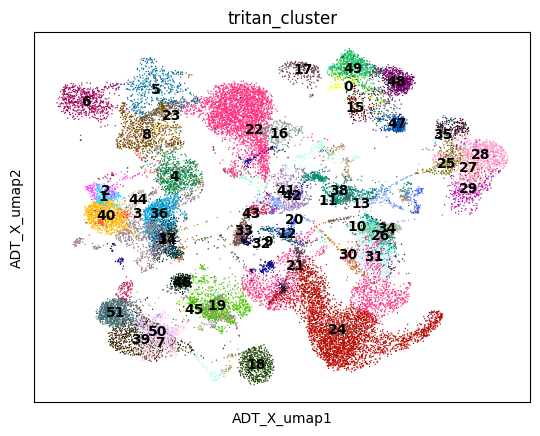

In [59]:
sc.pl.embedding(mdata, color ='tritan_cluster', basis='ADT_X_umap',legend_loc ='on data')

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


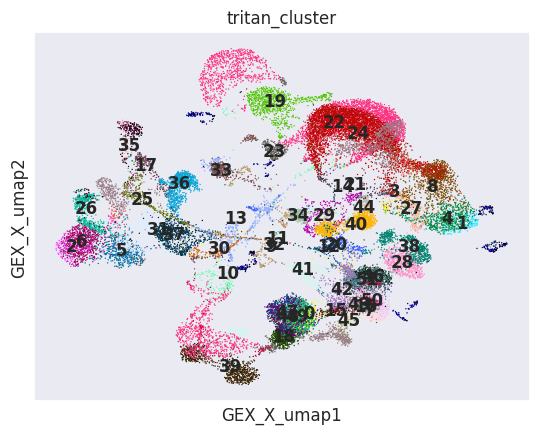

In [69]:
sc.pl.embedding(mdata, color ='tritan_cluster', basis='GEX_X_umap',legend_loc ='on data')

### Find signature feature groups for each cell cype

In [63]:
S_gene = tritan.S_gene
S_adt = tritan.S_atac
S_gene = normalize(S_gene, axis=0, norm='max')
S_adt = normalize(S_adt, axis=0, norm='max')

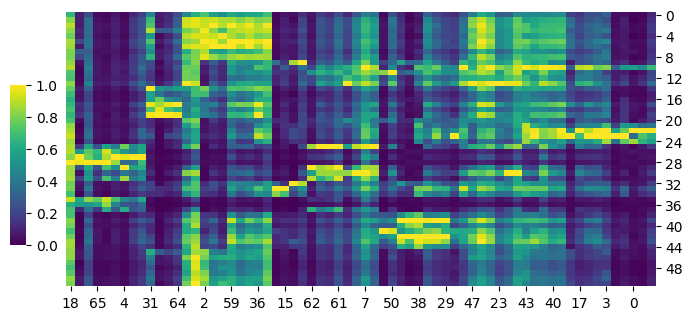

In [64]:
cg = sns.clustermap(S_gene,row_cluster=False,col_cluster=True,figsize=(8, 4), metric='correlation',cbar_pos=(0.14, .2, .02, .4),cmap='viridis')
cg.ax_row_dendrogram.set_visible(False) 
cg.ax_col_dendrogram.set_visible(False)

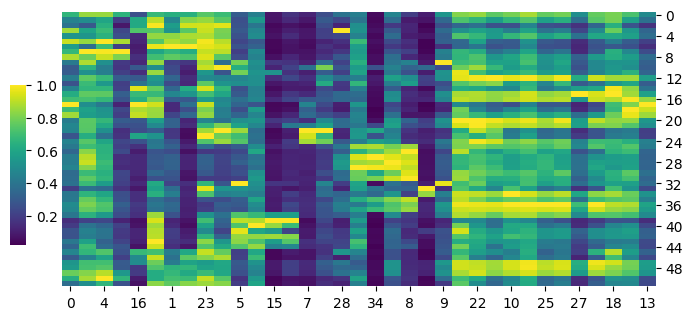

In [65]:
cg = sns.clustermap(S_adt,row_cluster=False,col_cluster=True,figsize=(8, 4), metric='correlation',cbar_pos=(0.14, .2, .02, .4),cmap='viridis')
cg.ax_row_dendrogram.set_visible(False) 
cg.ax_col_dendrogram.set_visible(False)

### Find associations of feature groups across omics

In [66]:
def np_pearson_cor(x, y):
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)

In [67]:
I = np_pearson_cor(S_adt,S_gene)

Text(15, 1.5, 'correlation matrix')

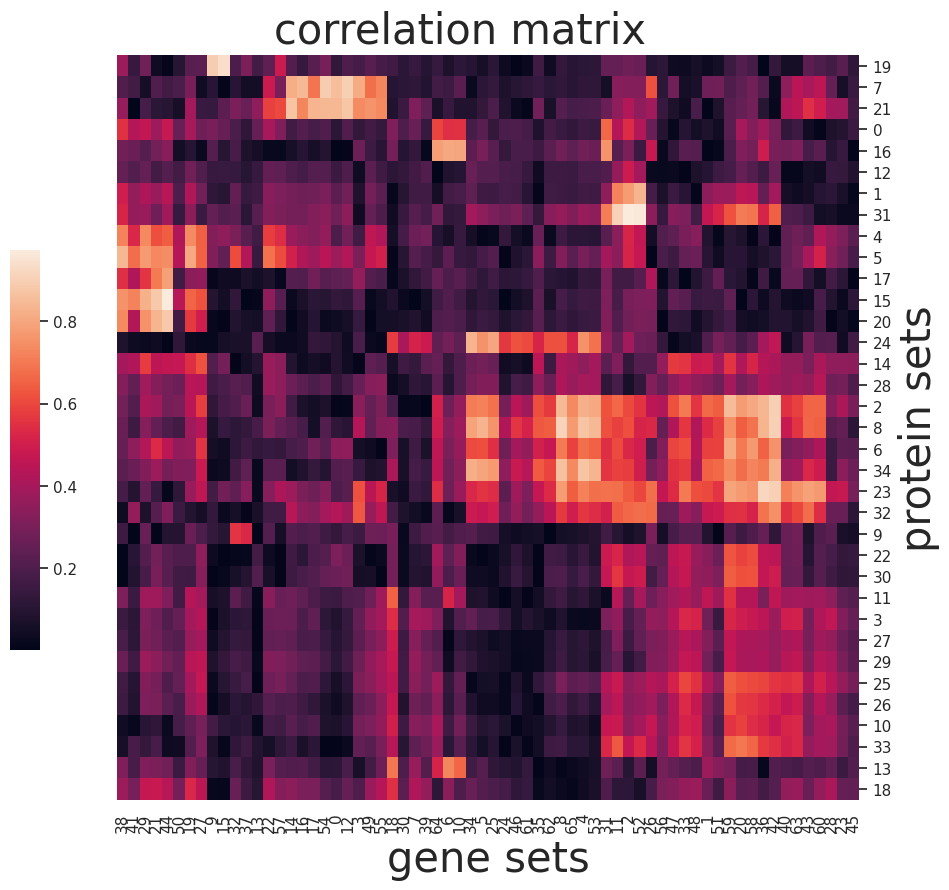

In [68]:
sns.set(font_scale=1)
g=sns.clustermap(np.abs(I),figsize=(10, 10),
    cbar_pos=(0.1, .2, .03, .4), metric='correlation',yticklabels=True,xticklabels=True)
ax = g.ax_heatmap
g.ax_row_dendrogram.set_visible(False) 
g.ax_col_dendrogram.set_visible(False)
ax.set_xlabel('gene sets', fontsize=30)
ax.set_ylabel('protein sets', fontsize=30)
plt.title('correlation matrix', fontsize=30,x=15,y=1.5)

## Saving the process

In [ ]:
mdata.write("./cite_seq.h5mu")